# Generate data

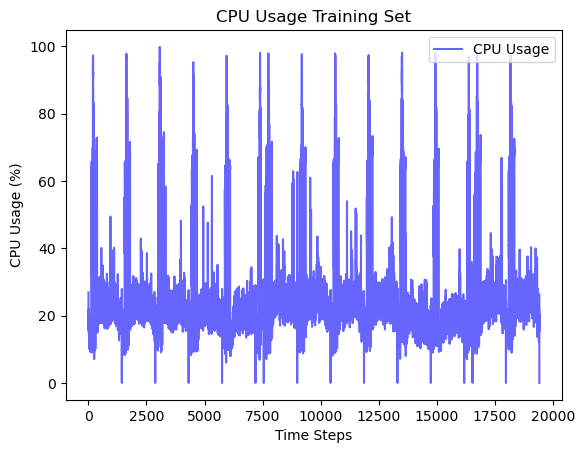

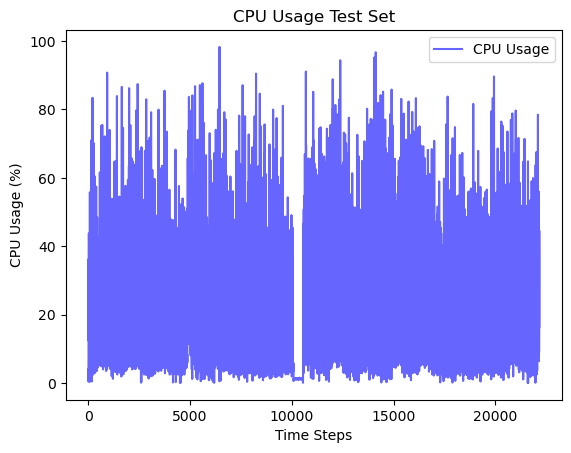

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

cpu_data = pd.read_csv('../Utilities\csv\cpu_usage_data_train.csv')
cpu_data = create_time_features(cpu_data)
test_data = pd.read_csv('../Utilities/csv/cpu_usage_data_test.csv')
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
test_data.set_index('datetime', inplace=True)
test_data = test_data.sort_index()
test_data_resampled = test_data.resample('T').asfreq()
test_data_resampled[['cpu_usage']] = test_data_resampled[['cpu_usage']].interpolate(method='cubic')
test_data.reset_index(inplace=True)
test_data_resampled.reset_index(inplace=True)
test_data = create_time_features(test_data_resampled)
test_data_cleaned = test_data[(test_data[['cpu_usage']] >= 0).all(axis=1)].copy()
test_data_cleaned = test_data_cleaned[(test_data_cleaned[['cpu_usage']] <= 100).all(axis=1)].copy()

file_path = "../Utilities/csv/cpu_usage_train.csv"
cpu_data.to_csv(file_path, index=False)

file_path = "../Utilities/csv/cpu_usage_test.csv"
test_data_cleaned.to_csv(file_path, index=False)

plt.plot(cpu_data['cpu_usage'], label='CPU Usage', color='blue', alpha=0.6)
plt.title('CPU Usage Training Set')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

plt.plot(test_data_cleaned['cpu_usage'], label='CPU Usage', color='blue', alpha=0.6)
plt.title('CPU Usage Test Set')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

# Generate Replicas

                 datetime  cpu_usage  hour  day_of_week  month  day_of_month  \
0     2010-11-24 00:01:00      26.92     0            2     11            24   
1     2010-11-24 00:02:00      19.27     0            2     11            24   
2     2010-11-24 00:03:00      15.73     0            2     11            24   
3     2010-11-24 00:04:00      16.70     0            2     11            24   
4     2010-11-24 00:05:00      20.57     0            2     11            24   
...                   ...        ...   ...          ...    ...           ...   
19420 2010-08-12 23:55:00      15.17    23            3      8            12   
19421 2010-08-12 23:56:00      17.17    23            3      8            12   
19422 2010-08-12 23:57:00      15.57    23            3      8            12   
19423 2010-08-12 23:58:00      19.93    23            3      8            12   
19424 2010-08-12 23:59:00       0.00    23            3      8            12   

       is_weekend  replicas  
0        

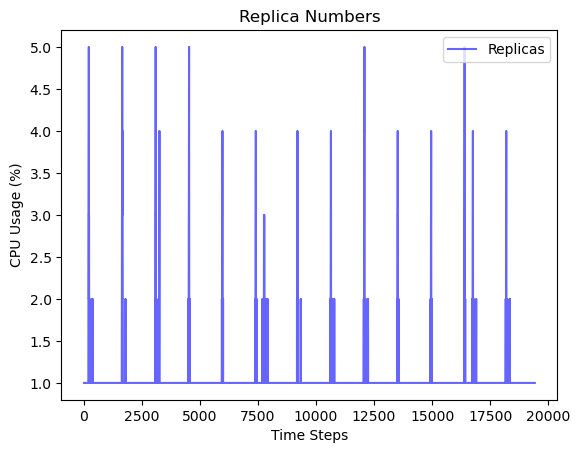

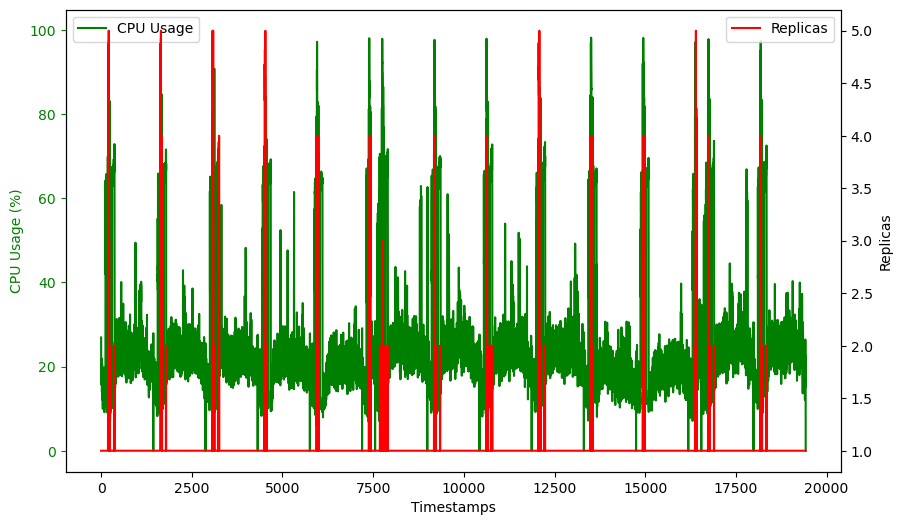

In [5]:
# Variables for tracking cooldown periods and consecutive low CPU usage
scale_up_cooldown = 5  # No scale-up allowed for 5 timesteps after the last scale-up
scale_down_consecutive = 2  # CPU must be below threshold for 2 consecutive timesteps to scale down

# Trackers
time_since_last_scale_up = scale_up_cooldown  # Initialize at cooldown to allow immediate scaling if needed
consecutive_below_threshold = 0  # Track consecutive timesteps below threshold

initial_replicas = 1

# Create a new column 'replicas' based on the CPU usage and SLA threshold (70%)
# We'll increase replicas by 1 each time CPU usage exceeds or equals 70%
threshold = 70
replicas = []
current_replicas = initial_replicas

# Iterate through CPU usage data with the new logic
for cpu_usage in cpu_data['cpu_usage']:
    # Check if scaling up is allowed
    if cpu_usage >= threshold:
        if time_since_last_scale_up >= scale_up_cooldown:
            current_replicas += 1  # Scale up
            time_since_last_scale_up = 0  # Reset cooldown
        else:
            time_since_last_scale_up += 1  # Increment cooldown timer
        consecutive_below_threshold = 0  # Reset consecutive below counter
    
    # Check for scaling down
    else:
        consecutive_below_threshold += 1
        if consecutive_below_threshold >= scale_down_consecutive and current_replicas > 1:
            current_replicas -= 1  # Scale down
            consecutive_below_threshold = 0  # Reset consecutive counter
        time_since_last_scale_up += 1  # Continue cooldown for scale up

    # Append the current number of replicas to the list
    replicas.append(current_replicas)

# Add the updated replicas to the dataframe
cpu_data['replicas'] = replicas

# Display the first few rows to check results
print(cpu_data)

plt.plot(cpu_data['replicas'], label='Replicas', color='blue', alpha=0.6)
plt.title('Replica Numbers')
plt.xlabel('Time Steps')
plt.ylabel('CPU Usage (%)')
plt.legend(loc='upper right')
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(cpu_data['cpu_usage'], 'g-', label='CPU Usage')
ax1.set_xlabel('Timestamps')
ax1.set_ylabel('CPU Usage (%)', color='g')
ax1.tick_params('y', colors='g')
ax2 = ax1.twinx()
ax2.plot(cpu_data['replicas'], 'r-', label='Replicas')
ax2.set_ylabel('Replicas')
ax2.tick_params('y')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# # Save the dataset to a CSV file
file_path = "../Utilities/csv/cpu_replicas.csv"
cpu_data.to_csv(file_path, index=False)

# Predict Workload

In [6]:
# Load your data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')

# Parse the datetime column
cpu_data['datetime'] = pd.to_datetime(cpu_data['datetime'])

# Drop datetime column if needed
cpu_data = cpu_data.drop(columns=['datetime'])

# Separate features and target before scaling
features = cpu_data.drop(columns=['cpu_usage'])  # Assuming 'cpu_usage' is the target column
target = cpu_data[['cpu_usage']]  # The target column

# Scale features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Use `X_scaled` and `y_scaled` for creating sequences


def create_sequences_multi_step(X_data, y_data, seq_length, pred_steps):
    X_sequences, y_sequences = [], []
    for i in range(len(X_data) - seq_length - pred_steps + 1):
        # Input sequences: last 'seq_length' timesteps of features
        X_sequences.append(X_data[i:i + seq_length])  # Shape will be (seq_length, n_features)
        # Labels: next 'pred_steps' values of the target feature
        y_sequences.append(y_data[i + seq_length:i + seq_length + pred_steps, 0])  # Predicting the next 10 values for the target feature 
    return np.array(X_sequences), np.array(y_sequences)


# In 10 minute increments
prediction_steps = 10
prediction_lookup = 60
X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, prediction_lookup, prediction_steps)

print("X_seq shape:", X_seq.shape)  # Should be (n_samples, seq_length, n_features)
print("y_seq shape:", y_seq.shape)  # Should be (n_samples, 10) for one feature

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=150, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100, activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(prediction_steps))

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping, model_checkpoint])

mse_lstm = lstm_model.evaluate(X_test, y_test)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

X_seq shape: (19356, 60, 5)
y_seq shape: (19356, 10)
Epoch 1/50
484/484 [==============================] - ETA: 0s - loss: 0.0237
Epoch 1: val_loss improved from inf to 0.01300, saving model to best_model.hdf5


c:\Users\brand\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


484/484 [==============================] - 180s 341ms/step - loss: 0.0237 - val_loss: 0.0130
Epoch 2/50
484/484 [==============================] - ETA: 0s - loss: 0.0151
Epoch 2: val_loss improved from 0.01300 to 0.01266, saving model to best_model.hdf5
484/484 [==============================] - 220s 455ms/step - loss: 0.0151 - val_loss: 0.0127
Epoch 3/50
484/484 [==============================] - ETA: 0s - loss: 0.0172
Epoch 3: val_loss improved from 0.01266 to 0.01139, saving model to best_model.hdf5
484/484 [==============================] - 160s 330ms/step - loss: 0.0172 - val_loss: 0.0114
Epoch 4/50
484/484 [==============================] - ETA: 0s - loss: 0.0133
Epoch 4: val_loss did not improve from 0.01139
484/484 [==============================] - 236s 487ms/step - loss: 0.0133 - val_loss: 0.0164
Epoch 5/50
484/484 [==============================] - ETA: 0s - loss: 0.0128
Epoch 5: val_loss improved from 0.01139 to 0.01058, saving model to best_model.hdf5
484/484 [============

# Forecast prediction

121/121 [==============================] - 16s 121ms/step
RMSE: 2.9913633199513447, MSE: 8.948254511950331


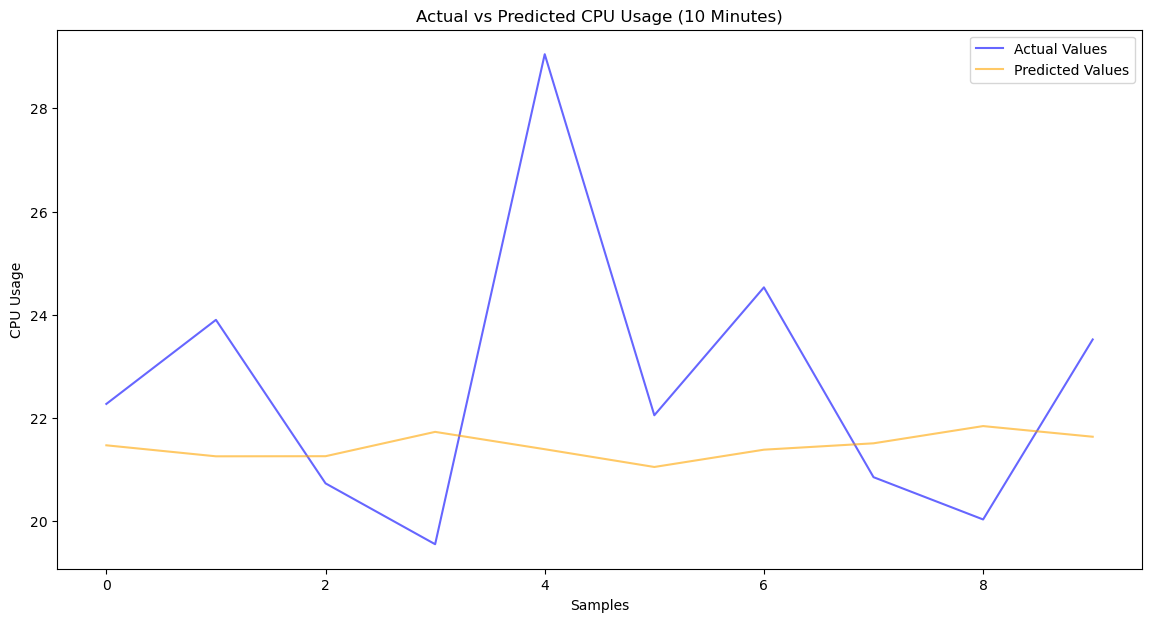

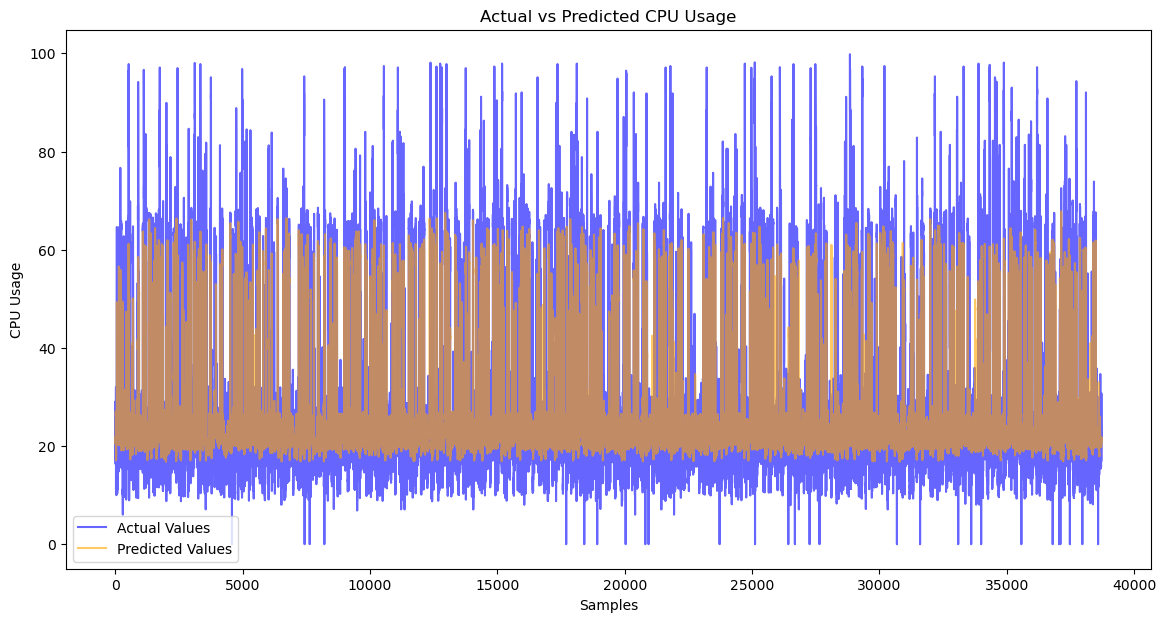

In [7]:
# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform the predictions using the target scaler
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# If `y_test` also needs inverse transforming
y_test_unscaled = target_scaler.inverse_transform(y_test)


# Calculate MSE and RMSE
mse_lstm = mean_squared_error(y_test_unscaled[0], y_pred_unscaled[0])
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled[0], label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred_unscaled[0], label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage (10 Minutes)')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# Plotting Actual vs Predicted values
y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# Predicting number of replicas

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error (MSE): 0.044917184845502445


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


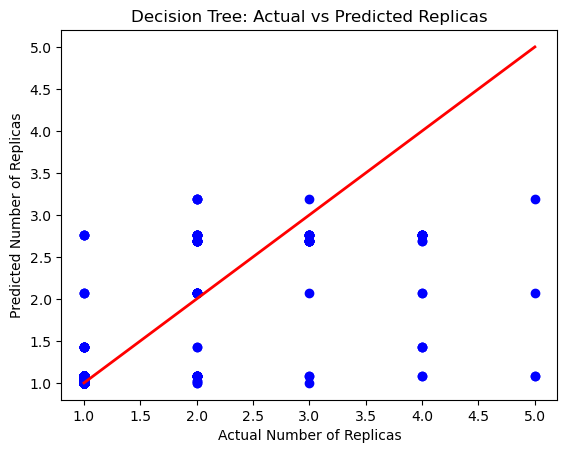

121/121 [==============================] - 18s 146ms/step
Predicted number of replicas for future CPU usage ([[21.467775 21.254417 21.256453 ... 21.506418 21.840443 21.6339  ]
 [20.818188 20.511244 20.559439 ... 20.948029 21.38778  21.094145]
 [26.664755 26.287024 26.316143 ... 26.545685 26.97478  26.584856]
 ...
 [20.801975 20.425667 20.496452 ... 20.917326 21.241966 21.04702 ]
 [20.556602 19.797134 20.334251 ... 20.643085 20.69175  20.67459 ]
 [21.370821 21.027885 21.051876 ... 21.403797 21.716948 21.541615]]): [1.00339929 1.00339929 1.00339929 ... 1.00339929 1.00339929 1.00339929]


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')

# Split the data
X = replicas_data[['cpu_usage']]
y = replicas_data['replicas']
X_train_replicas, X_test_replicas, y_train_replicas, y_test_replicas = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_replicas.values, y_train_replicas.values)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Predict with the best model
best_model = grid_search.best_estimator_
y_pred_replicas = best_model.predict(X_test_replicas)

# Evaluate the model
mse = mean_squared_error(y_test_replicas, y_pred_replicas)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.scatter(y_test_replicas, y_pred_replicas, color='blue')
plt.plot([y_test_replicas.min(), y_test_replicas.max()], [y_test_replicas.min(), y_test_replicas.max()], color='red', lw=2)
plt.xlabel('Actual Number of Replicas')
plt.ylabel('Predicted Number of Replicas')
plt.title('Decision Tree: Actual vs Predicted Replicas')
plt.show()

# Predict using LSTM output
predictions = lstm_model.predict(X_test)
# cpu_usage_scaler = MinMaxScaler()
# cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_rescaled = target_scaler.inverse_transform(predictions)

future_replicas = best_model.predict(predictions_rescaled.reshape(-1, 1))
print(f'Predicted number of replicas for 10 mins future CPU usage ({predictions_rescaled[0][-1]}): {future_replicas[0][-1]}')

# Detect Burst

In [9]:
import time
from kubernetes import client, config
import requests
import json
from datetime import datetime, timedelta

def get_time_range():
    end_time = int(time.time())  # Current timestamp in seconds
    start_time = end_time - (3 * 3600) # Hours in seconds
    return start_time, end_time

# Prometheus server URL (adjust according to your setup)
PROMETHEUS_URL = "http://localhost:9090"

def query_prometheus_range(query, start_time, end_time, step):
    params = {
        'query': query,
        'start': start_time,
        'end': end_time,
        'step': step  # Interval between points (e.g., 60s = 1 minute intervals)
    }
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query_range", params=params)
    return response.json()

# Function to get CPU usage for a pod over the past hour
def get_pod_cpu_usage_range(pod_name, start_time, end_time):
    # Prometheus query to get CPU usage over the last hour (rate over 1 minute)
    query = f'avg((sum(rate(container_cpu_usage_seconds_total{{pod=~"{pod_name}-.*"}}[1m])) by (pod)) / (sum(kube_pod_container_resource_limits{{pod=~"{pod_name}-.*", resource="cpu"}}) by (pod))) * 100'

    # Query Prometheus with a 60-second step interval
    result = query_prometheus_range(query, start_time, end_time, step="60")

    return result

# Function to convert the Prometheus result to a pandas DataFrame
def prometheus_to_dataframe(prometheus_result):
    if not prometheus_result or 'data' not in prometheus_result:
        return pd.DataFrame()  # Return an empty DataFrame if there's no data

    # Extract the 'values' from the first result (assuming only one pod)
    values = prometheus_result['data']['result'][0]['values']

    # Create a DataFrame from the values
    df = pd.DataFrame(values, columns=['timestamp', 'value'])

    # Convert UNIX timestamp to human-readable datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # Convert the value column to float
    df['value'] = df['value'].astype(float)

    return df

# Get weather data
def get_weather_data(start_time, end_time):
    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

    API_KEY = 'DbiSeuEozdnpBiOOJ25UH66tyRj17LDx'
    LOCATION = "51.507407,-0.12772404"  # London

    start_time = datetime.utcfromtimestamp(start_time).isoformat() + "Z"
    end_time = datetime.utcfromtimestamp(end_time).isoformat() + "Z"

    # Build the API URL for the Timeline API
    URL = f"https://api.tomorrow.io/v4/timelines?apikey={API_KEY}"

    # Define the query parameters
    query_params = {
        "location": LOCATION,
        "fields": ["temperature", "humidity", "windSpeed"],
        "units": "metric",  # For Celsius and kph
        "timesteps": "1m",  # 1-minute intervals
        "startTime": start_time,
        "endTime": end_time,
    }

    # Make the API request
    response = requests.get(URL, params=query_params)
    data = response.json()
    # Check for a successful response
    if response.status_code == 200:
        # Create a list to store the data
        weather_data = []
        
        # Loop through each interval and extract the weather data
        for interval in data["data"]["timelines"][0]["intervals"]:
            datetime_obj = datetime.strptime(interval["startTime"], '%Y-%m-%dT%H:%M:%SZ')
            formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')
            weather_record = {
                "time": formatted_timestamp,
                "temperature": interval["values"]["temperature"],
                "humidity": interval["values"]["humidity"],
                "wind_speed": interval["values"]["windSpeed"],
            }
            weather_data.append(weather_record)
        
        # Convert the list of dictionaries to a DataFrame
        df = pd.DataFrame(weather_data)
    else:
        print(f"Error: {response.status_code}, {data['message']}")
    return df

def get_dataset():
    start_time, end_time = get_time_range()
    weather_data_1h = get_weather_data(start_time, end_time)
    pod_cpu_data = get_pod_cpu_usage_range("microsvc", start_time, end_time)

    # Convert the data to a pandas DataFrame
    cluster_data_1h = prometheus_to_dataframe(pod_cpu_data)

    cluster_data_1h['timestamp'] = pd.to_datetime(cluster_data_1h['timestamp']).dt.floor('T')
    weather_data_1h['time'] = pd.to_datetime(weather_data_1h['time']).dt.floor('T')
    full_1h_data = pd.merge(cluster_data_1h, weather_data_1h, left_on='timestamp', right_on='time')
    full_1h_data = full_1h_data.drop('time', axis=1)
    full_1h_data = full_1h_data.drop('timestamp', axis=1)
    full_1h_data.loc[:, 'temperature_lag_10_mins'] = full_1h_data['temperature'].shift(10)
    full_1h_data.loc[:, 'temperature_lag_1_hour'] = full_1h_data['temperature'].shift(60)
    full_1h_data.dropna(inplace=True)
    return full_1h_data

def create_sequences_multi_step(data, seq_length, pred_steps):
    sequences, labels = [], []
    for i in range(len(data) - seq_length - pred_steps + 1):
        sequences.append(data[i:i + seq_length, :-1])  # Features (last hour of data)
        labels.append(data[i + seq_length:i + seq_length + pred_steps, -1])  # Predict next 10 values
    return np.array(sequences), np.array(labels)

# Load kube config
config.load_kube_config()
# If running inside the cluster, use:
# config.load_incluster_config()

def scale_out(additional_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = current_replicas + additional_replicas
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled out to {new_replicas} replicas.")
    return new_replicas

def scale_in(remove_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = max(current_replicas - remove_replicas, 1)
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled in to {new_replicas} replicas.")
    return new_replicas

def detect_burst(monitoring_interval, window_size, resource_prediction_model, replica_prediction_model, replicas):
    is_burst = False
    replicas_before_burst = 0
    past_predictions = np.array([])
    feature_scaler_burst = MinMaxScaler()
    # while True:
    x = 0
    while x < 5:
        x += 1
        time.sleep(monitoring_interval)
        full_3h_data = get_dataset()
        scaled_data = feature_scaler_burst.fit_transform(full_3h_data)
        # In 10 minute increments
        prediction_steps = 10
        prediction_lookup = 60
        predict_data, predict_labels = create_sequences_multi_step(scaled_data, prediction_lookup, prediction_steps)
        cpu_predictions = resource_prediction_model.predict(predict_data)
        predictions_rescaled = feature_scaler_burst.inverse_transform(cpu_predictions)
        n_predicted = replica_prediction_model.predict(predictions_rescaled.reshape(-1, 1))
        past_predictions = np.append(past_predictions, n_predicted)
        sd_max = 0
        n_max = 0
        for i in range(1, window_size + 1):
            sigma_i = np.std(past_predictions)

            if sigma_i > sd_max:
                sd_max = sigma_i
                n_max = max(past_predictions.flatten())

        if sd_max >= 2 and not is_burst:
            # Detected burst, increase replicas to n_max
            replicas_during_burst = n_max
            is_burst = True
            replicas_before_burst = n_predicted  # Store current predicted replicas before burst
        elif sd_max >= 2 and is_burst:
            # Continuation of the burst
            replicas_during_burst = n_max
        elif sd_max < 2 and is_burst:
            if replicas_before_burst > n_predicted:
                # Burst ending, scale back to predicted replicas
                replicas_during_burst = n_predicted
                is_burst = False
                replicas_before_burst = 0
            else:
                # Keep scaling at n_max
                replicas_during_burst = n_max
        else:
            # Normal condition, set replicas to predicted
            replicas_during_burst = n_predicted[0]

        current_replica_count = int(round(replicas))
        replicas_during_burst = int(round(replicas_during_burst))

        if current_replica_count < replicas_during_burst:
            additional_replicas = int(round(replicas_during_burst - current_replica_count))
            replicas = scale_out(additional_replicas, 'microsvc', namespace='default')
        elif current_replica_count > replicas_during_burst:
            replica_difference = int(round(current_replica_count - replicas_during_burst))
            replicas = scale_in(replica_difference, 'microsvc', namespace='default')
        else:
            print("No replica update needed")
        # Log the updated replica count
        print(f"Updated replica count: {replicas}")


api = client.AppsV1Api()
deployment = api.read_namespaced_deployment('microsvc', namespace='default')
replicas = deployment.spec.replicas
print(f"Original replica count: {replicas}")
detect_burst(60, 10, lstm_model, best_model, replicas)

MaxRetryError: HTTPSConnectionPool(host='kubernetes.docker.internal', port=6443): Max retries exceeded with url: /apis/apps/v1/namespaces/default/deployments/microsvc (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001E6CD255A10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

# Create HPA System

In [ ]:
# import joblib

# joblib.dump(model, 'cpu_usage_predictor.pkl')
# joblib.dump(best_model, 'replicas_predictor.pkl')
